In [51]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression as PySparkLinearRegression
from pyspark.ml.classification import RandomForestClassifier as PySparkRandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [52]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/us_tornado_dataset_1950_2021.csv')

In [53]:
print(df.head())

     yr  mo  dy        date  st  mag  inj  fat   slat   slon   elat   elon  \
0  1950   1   3  1950-01-03  IL    3    3    0  39.10 -89.30  39.12 -89.23   
1  1950   1   3  1950-01-03  MO    3    3    0  38.77 -90.22  38.83 -90.03   
2  1950   1   3  1950-01-03  OH    1    1    0  40.88 -84.58   0.00   0.00   
3  1950   1  13  1950-01-13  AR    3    1    1  34.40 -94.37   0.00   0.00   
4  1950   1  25  1950-01-25  IL    2    0    0  41.17 -87.33   0.00   0.00   

   len  wid  
0  3.6  130  
1  9.5  150  
2  0.1   10  
3  0.6   17  
4  0.1  100  


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67558 entries, 0 to 67557
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      67558 non-null  int64  
 1   mo      67558 non-null  int64  
 2   dy      67558 non-null  int64  
 3   date    67558 non-null  object 
 4   st      67558 non-null  object 
 5   mag     67558 non-null  int64  
 6   inj     67558 non-null  int64  
 7   fat     67558 non-null  int64  
 8   slat    67558 non-null  float64
 9   slon    67558 non-null  float64
 10  elat    67558 non-null  float64
 11  elon    67558 non-null  float64
 12  len     67558 non-null  float64
 13  wid     67558 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 7.2+ MB


In [55]:
print(df.describe())

                 yr            mo            dy           mag           inj  \
count  67558.000000  67558.000000  67558.000000  67558.000000  67558.000000   
mean    1991.341618      5.976761     15.921016      0.691273      1.437876   
std       19.330015      2.438192      8.736773      1.283375     18.263956   
min     1950.000000      1.000000      1.000000     -9.000000      0.000000   
25%     1976.000000      4.000000      8.000000      0.000000      0.000000   
50%     1994.000000      6.000000     16.000000      1.000000      0.000000   
75%     2008.000000      7.000000     24.000000      1.000000      0.000000   
max     2021.000000     12.000000     31.000000      5.000000   1740.000000   

                fat          slat          slon          elat          elon  \
count  67558.000000  67558.000000  67558.000000  67558.000000  67558.000000   
mean       0.090470     37.142412    -92.784618     22.730695    -56.245590   
std        1.484106      5.093979      8.689103    

In [56]:
print(df.isnull().sum())

yr      0
mo      0
dy      0
date    0
st      0
mag     0
inj     0
fat     0
slat    0
slon    0
elat    0
elon    0
len     0
wid     0
dtype: int64


In [57]:
# - 'yr', 'mo', 'dy': Year, Month, Day. Ensure these are integers.
for col in ['yr', 'mo', 'dy']:
    if col in df.columns:
        # It's good practice to ensure they are numeric before converting to int,
        # in case they were read as objects due to non-numeric characters.
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(int, errors='ignore')
        # If conversion creates NaNs (e.g., if there were non-numeric strings), handle them.
        if df[col].isnull().sum() > 0:
            print(f"Warning: NaNs created during numeric conversion of '{col}'. Dropping rows.")
            df.dropna(subset=[col], inplace=True)
        print(f"Ensured '{col}' is integer type.")

Ensured 'yr' is integer type.
Ensured 'mo' is integer type.
Ensured 'dy' is integer type.


In [58]:
# - 'slat', 'slon', 'elat', 'elon', 'len', 'wid': Should be float.
# Added 'elat' and 'elon' here
for col in ['slat', 'slon', 'elat', 'elon', 'len', 'wid']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().sum() > 0:
            print(f"Warning: NaNs created during numeric conversion of '{col}'. Dropping rows.")
            df.dropna(subset=[col], inplace=True)
        print(f"Ensured '{col}' is float type.")

Ensured 'slat' is float type.
Ensured 'slon' is float type.
Ensured 'elat' is float type.
Ensured 'elon' is float type.
Ensured 'len' is float type.
Ensured 'wid' is float type.


In [59]:
print("\nData types after correction:")
print(df.dtypes)


Data types after correction:
yr        int64
mo        int64
dy        int64
date     object
st       object
mag       int64
inj       int64
fat       int64
slat    float64
slon    float64
elat    float64
elon    float64
len     float64
wid       int64
dtype: object


In [60]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)
numerical_cols = ['yr', 'mo', 'dy', 'mag', 'inj', 'fat', 'slat', 'slon', 'elat', 'elon', 'len', 'wid']
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=[col], inplace=True)
    if col in ['yr', 'mo', 'dy', 'mag', 'inj', 'fat']:
        df[col] = df[col].astype(int)

In [61]:
# Re-creating engineered features
df['month_of_year'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['year'] = df['date'].dt.year
df['tornado_area_proxy'] = df['len'] * df['wid']
log_transform_features = ['inj', 'fat', 'len', 'wid']
for col in log_transform_features:
    df[f'log_{col}'] = np.log1p(df[col])
df = pd.get_dummies(df, columns=['st'], prefix='state', dummy_na=False)

In [62]:
# Define features and target based on the preprocessed DataFrame
TARGET_COL = 'mag'
feature_cols = [col for col in df.columns if col not in [TARGET_COL, 'date', 'inj', 'fat', 'len', 'wid']]
feature_cols = [col for col in feature_cols if col in df.columns]
X = df[feature_cols]
y = df[TARGET_COL]

In [63]:
# 2. Train and Evaluate Scikit-learn Models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class = y_train.astype(int)
y_test_class = y_test.astype(int)

In [64]:
# Scikit-learn Linear Regression (Regression)
start_time_lr_sklearn = time.time()
lr_sklearn = LinearRegression().fit(X_train, y_train)
y_pred_lr_sklearn = lr_sklearn.predict(X_test)
training_duration_lr_sklearn = time.time() - start_time_lr_sklearn
rmse_lr_sklearn = np.sqrt(mean_squared_error(y_test, y_pred_lr_sklearn))
r2_lr_sklearn = r2_score(y_test, y_pred_lr_sklearn)

# Print the results
print("--- Scikit-learn Linear Regression Model Results ---")
print(f"Training Time: {training_duration_lr_sklearn:.4f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse_lr_sklearn:.4f}")
print(f"R-squared (R2): {r2_lr_sklearn:.4f}")

--- Scikit-learn Linear Regression Model Results ---
Training Time: 0.2506 seconds
Root Mean Squared Error (RMSE): 1.0141
R-squared (R2): 0.3517


In [65]:
# Scikit-learn Random Forest Classifier
start_time_rfc_sklearn = time.time()
rfc_sklearn = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1).fit(X_train, y_train_class)
y_pred_rfc_sklearn = rfc_sklearn.predict(X_test)
training_duration_rfc_sklearn = time.time() - start_time_rfc_sklearn
accuracy_rfc_sklearn = accuracy_score(y_test_class, y_pred_rfc_sklearn)

# Print the results
print("--- Scikit-learn Random Forest Classifier Results ---")
print(f"Training Time: {training_duration_rfc_sklearn:.4f} seconds")
print(f"Accuracy: {accuracy_rfc_sklearn:.4f}")

--- Scikit-learn Random Forest Classifier Results ---
Training Time: 13.5476 seconds
Accuracy: 0.6755


In [66]:
import statsmodels.api as sm

# Convert boolean columns to integers (0s and 1s)
X_train_ols = X_train.astype(int)

# Add constant
X_train_ols = sm.add_constant(X_train_ols)

# Linear Regression (OLS Summary) ---
ols_model = sm.OLS(y_train, X_train_ols).fit()
print(" OLS Summary Report for Linear Regression ")
print(ols_model.summary())
print("\n")

--- OLS Summary Report for Linear Regression ---
                            OLS Regression Results                            
Dep. Variable:                    mag   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     414.4
Date:                Thu, 17 Jul 2025   Prob (F-statistic):               0.00
Time:                        04:21:44   Log-Likelihood:                -79480.
No. Observations:               54046   AIC:                         1.591e+05
Df Residuals:                   53980   BIC:                         1.597e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

--- Generating Scikit-learn Random Forest Classifier Confusion Matrix ---


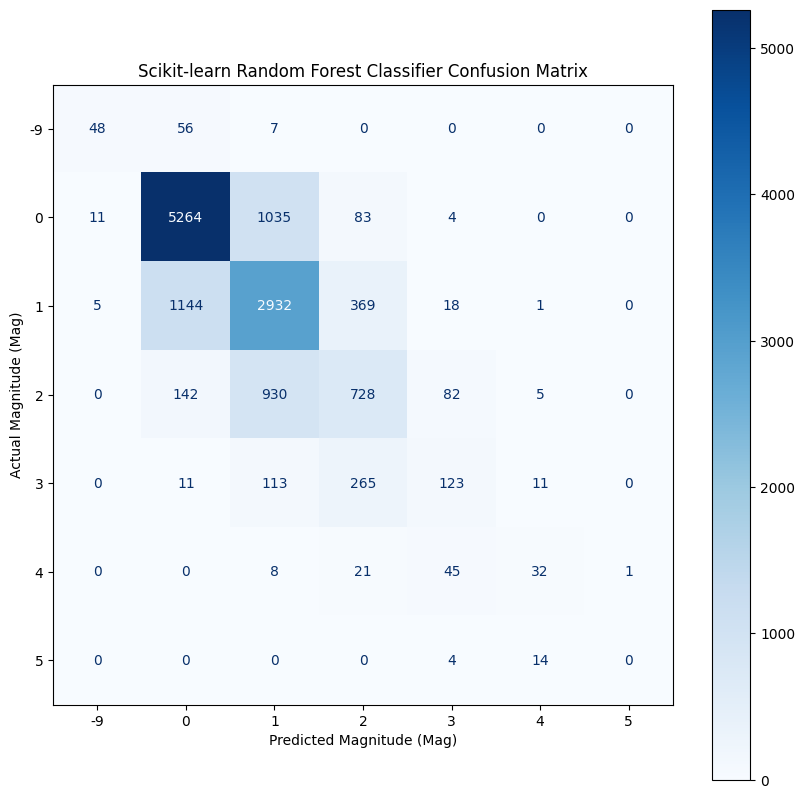

In [67]:
print("--- Generating Scikit-learn Random Forest Classifier Confusion Matrix ---")
cm = confusion_matrix(y_test_class, y_pred_rfc_sklearn, labels=rfc_sklearn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_sklearn.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Scikit-learn Random Forest Classifier Confusion Matrix')
plt.xlabel('Predicted Magnitude (Mag)')
plt.ylabel('Actual Magnitude (Mag)')
plt.show()

In [68]:

# --- 4. Train and Evaluate PySpark Models ---
spark = SparkSession.builder.appName("TornadoPySparkML").getOrCreate()
spark_df = spark.createDataFrame(df)
feature_cols_pyspark = [col for col in feature_cols if col in spark_df.columns]
vector_assembler = VectorAssembler(inputCols=feature_cols_pyspark, outputCol="features")
transformed_df = vector_assembler.transform(spark_df)
transformed_df.cache()
(training_data, test_data) = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [69]:
# PySpark Linear Regression (Regression)
start_time_lr_pyspark = time.time()
lr_pyspark = PySparkLinearRegression(featuresCol='features', labelCol=TARGET_COL).fit(training_data)
training_duration_lr_pyspark = time.time() - start_time_lr_pyspark
lr_predictions_pyspark = lr_pyspark.transform(test_data)
evaluator_rmse_pyspark = RegressionEvaluator(labelCol=TARGET_COL, metricName="rmse")
rmse_lr_pyspark = evaluator_rmse_pyspark.evaluate(lr_predictions_pyspark)
evaluator_r2_pyspark = RegressionEvaluator(labelCol=TARGET_COL, metricName="r2")
r2_lr_pyspark = evaluator_r2_pyspark.evaluate(lr_predictions_pyspark)


# Print the results
print("--- PySpark Linear Regression Model Results ---")
print(f"Training Time: {training_duration_lr_pyspark:.4f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse_lr_pyspark:.4f}")
print(f"R-squared (R2): {r2_lr_pyspark:.4f}")

--- PySpark Linear Regression Model Results ---
Training Time: 7.1631 seconds
Root Mean Squared Error (RMSE): 1.0460
R-squared (R2): 0.3383


In [70]:
# PySpark Random Forest Classifier
start_time_rfc_pyspark = time.time()

# Filter out rows where 'mag' is -9.0
filtered_training_data = training_data.filter(training_data[TARGET_COL] >= 0)

rfc_pyspark = PySparkRandomForestClassifier(featuresCol='features', labelCol=TARGET_COL, numTrees=100, seed=42).fit(filtered_training_data)
training_duration_rfc_pyspark = time.time() - start_time_rfc_pyspark

# Filter test data as well for consistency
filtered_test_data = test_data.filter(test_data[TARGET_COL] >= 0)
rfc_predictions_pyspark = rfc_pyspark.transform(filtered_test_data)

evaluator_acc_pyspark = MulticlassClassificationEvaluator(labelCol=TARGET_COL, metricName="accuracy")
accuracy_rfc_pyspark = evaluator_acc_pyspark.evaluate(rfc_predictions_pyspark)

# Print the results
print("--- PySpark Random Forest Classifier Results ---")
print(f"Training Time: {training_duration_rfc_pyspark:.4f} seconds")
print(f"Accuracy: {accuracy_rfc_pyspark:.4f}")

--- PySpark Random Forest Classifier Results ---
Training Time: 15.2746 seconds
Accuracy: 0.6105


/tmp/ipython-input-71-1744190158.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='viridis', ax=ax1)
/tmp/ipython-input-71-1744190158.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Performance Metric', data=comparison_df, palette='plasma', ax=ax2)


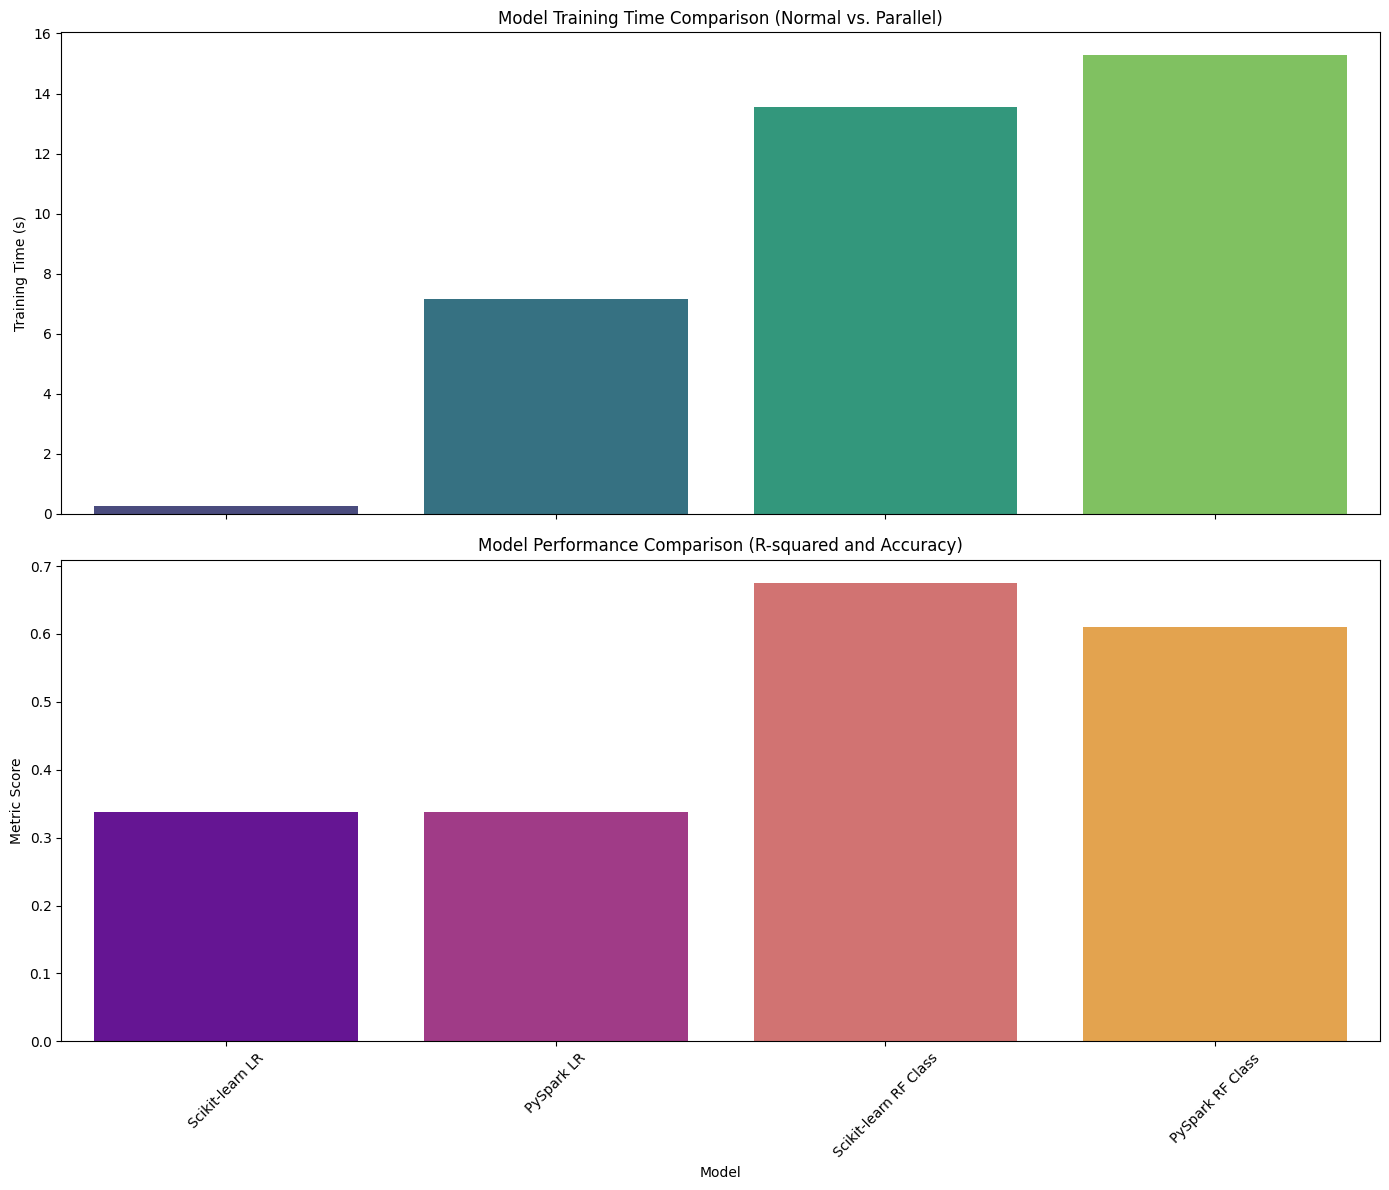

In [71]:
# --- 5. Generate Performance Comparison Visualization ---
comparison_data = {
    'Model': ['Scikit-learn LR', 'PySpark LR', 'Scikit-learn RF Class', 'PySpark RF Class'],
    'Training Time (s)': [training_duration_lr_sklearn, training_duration_lr_pyspark, training_duration_rfc_sklearn, training_duration_rfc_pyspark],
    'Performance Metric': [r2_lr_pyspark, r2_lr_pyspark, accuracy_rfc_sklearn, accuracy_rfc_pyspark],
    'Metric Type': ['R-squared', 'R-squared', 'Accuracy', 'Accuracy']
}
comparison_df = pd.DataFrame(comparison_data)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, palette='viridis', ax=ax1)
ax1.set_title('Model Training Time Comparison (Normal vs. Parallel)')
ax1.set_ylabel('Training Time (s)')
ax1.set_xlabel('')
sns.barplot(x='Model', y='Performance Metric', data=comparison_df, palette='plasma', ax=ax2)
ax2.set_title('Model Performance Comparison (R-squared and Accuracy)')
ax2.set_ylabel('Metric Score')
ax2.set_xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
